## __Importing Basic Library__

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## __Importing Dataset__

In [ ]:
# upload kaggle.json file from your machine
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mch2001","key":"1bf23bc0b2b41184cb835083f07e451a"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!mkdir dataset
!unzip -qq /content/skin-cancer-mnist-ham10000.zip -d dataset

100% 5.19G/5.20G [00:35<00:00, 156MB/s]
100% 5.20G/5.20G [00:35<00:00, 157MB/s]


In [ ]:
data_dir = '/content/dataset/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
Label = data["label"]
Data = data.drop(columns=["label"])

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [ ]:
from sklearn.model_selection import train_test_split
# Data = Data.reshape(-1, 28, 28, 3)
X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [ ]:
np.unique(Label)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
labels = ['akiec',
          'bcc',
          'bkl',
          'df',
          'nv',
          'vasc',
          'mel']

lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma'
}



0 : akiec

1 : bcc

2 : bkl

3 : df

4 : nv

5 : vasc

6 : mel

### Labels

number of samples of each class in the whole dataset

In [ ]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(Label==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,6705
bcc,6705
bkl,6705
df,6705
nv,6705
vasc,6705
mel,6705


Obviously, we face an imbalanced dataset that has to be handled!

### Visualizing our data
5 images of each 7 classes

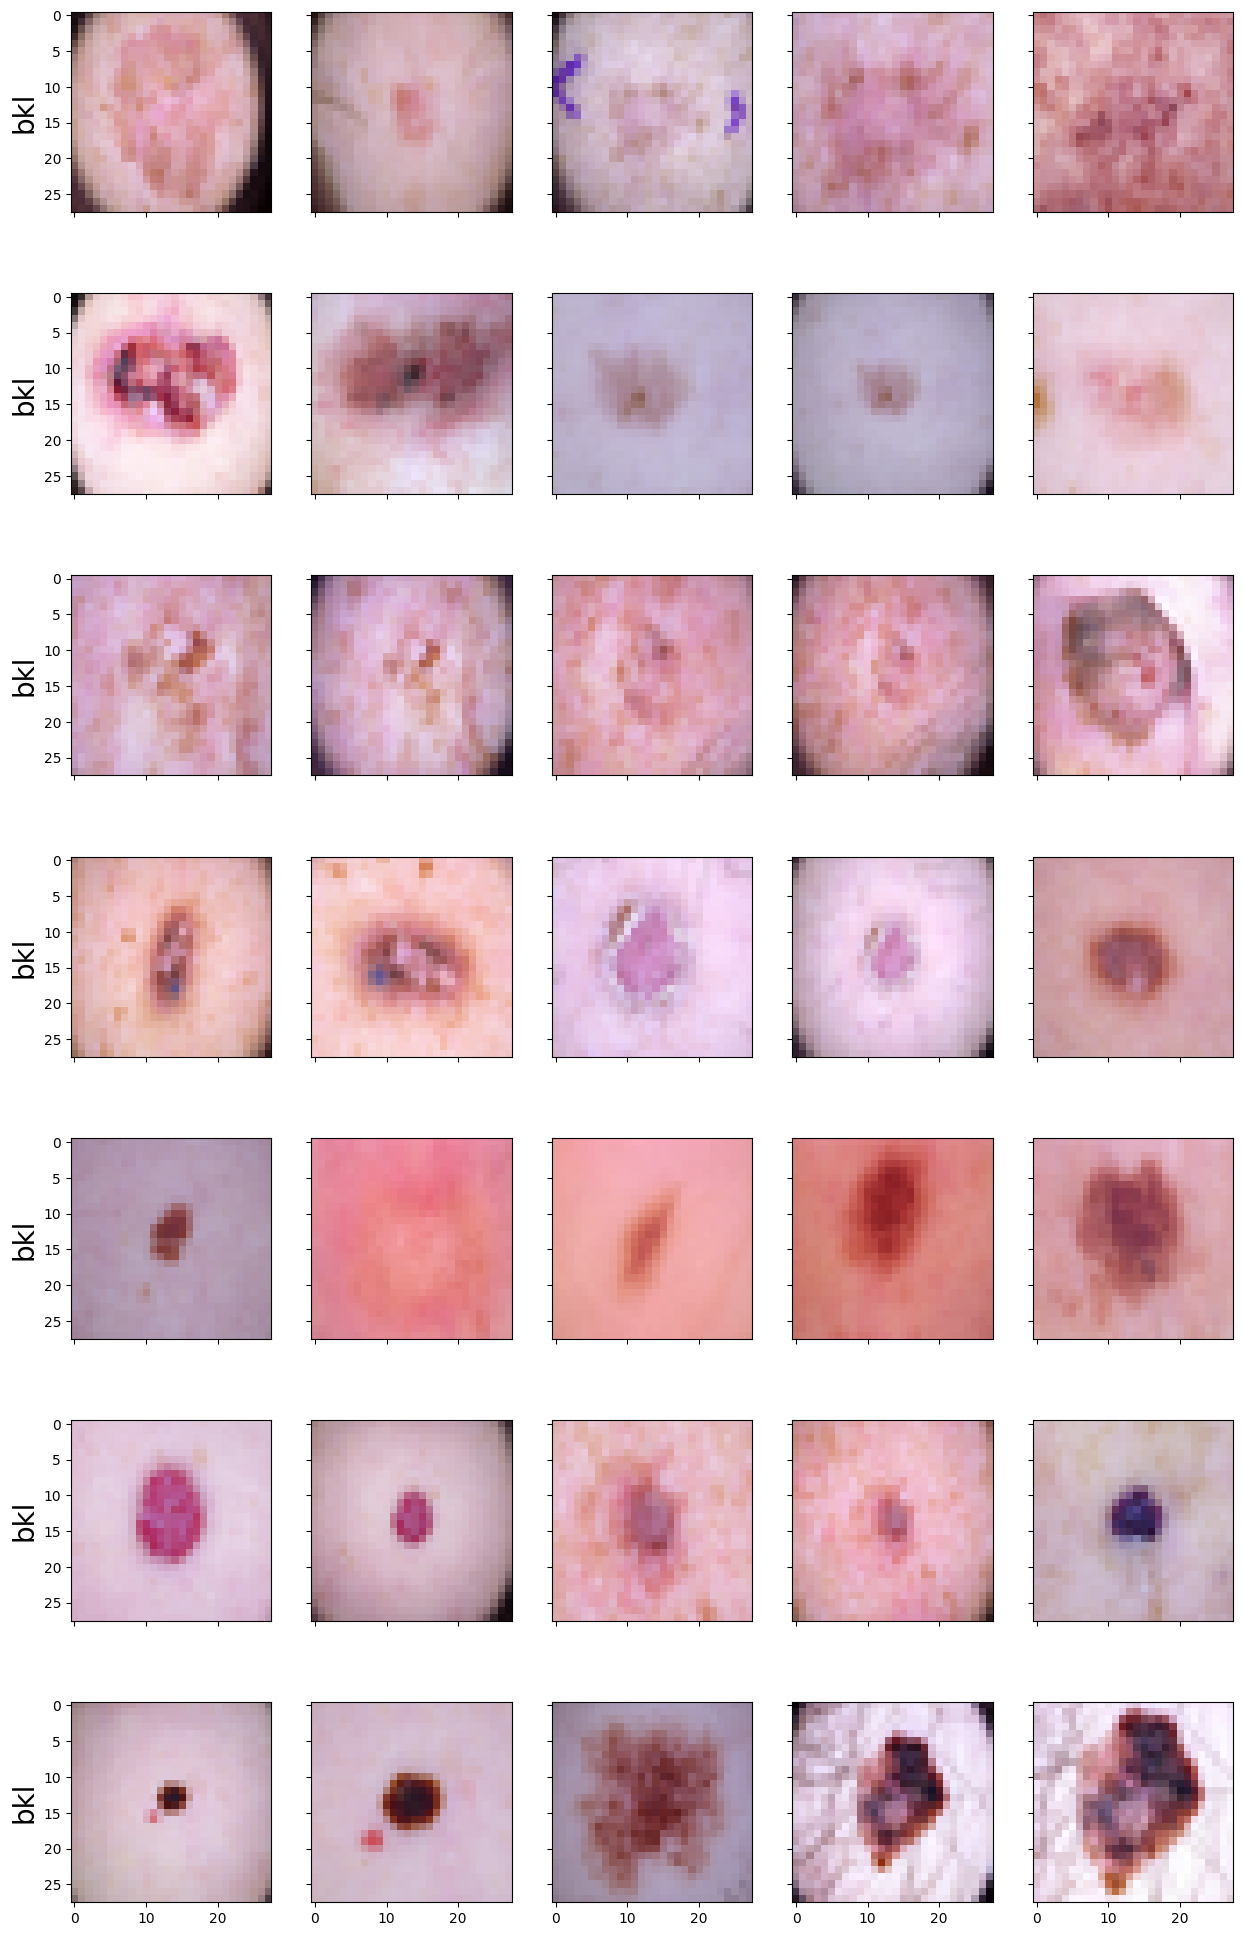

In [ ]:
fig, ax = plt.subplots(7, 5)
fig.set_figheight(25)
fig.set_figwidth(15)
for classes in range (7):
  for i, inx in enumerate(np.where(Label==classes)[0][:5]):
    ax[classes,i].imshow(Data[inx])
    ax[classes,i].set_ylabel(labels[Label[classes]],fontsize = 20.0)
    ax[classes,i].label_outer()

## __Data Preprocessing and Augmentation__

### Resampling

In [ ]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(y_train==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,5038
bcc,5016
bkl,5054
df,5076
nv,5042
vasc,5025
mel,4950


### Making Labels Categorical

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train.shape

(35201, 7)

### Image Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

batch_size=128
train_data = train_datagen.flow(X_train, y_train, batch_size = batch_size, seed=1)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_data = test_datagen.flow(X_test, y_test, batch_size=batch_size,seed=1)

In [ ]:
print(f'Train Set:      X:%s Y:%s' %(train_data.x.shape, train_data.y.shape))
print(f'Validation Set: X:%s Y:%s' %(val_data.x.shape, val_data.y.shape))

Train Set:      X:(35201, 28, 28, 3) Y:(35201, 7)
Validation Set: X:(11734, 28, 28, 3) Y:(11734, 7)


## __Model Creation__

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

In [ ]:
input_layer = Input(shape=(28,28,3))

# convolution block 1
cb11 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(input_layer)
cb12 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb11)
maxpl1 = MaxPool2D((2,2))(cb12)

#convolution block 2
cb21 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl1)
cb22 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb21)
maxpl2 = MaxPool2D((2,2))(cb22)

#convolution block 3
cb31 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl2)
cb32 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb31)
maxpl3 = MaxPool2D((2,2))(cb32)

#convolution block 4
cb41 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl3)
cb42 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb41)
cb43 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb42)
maxpl4 = MaxPool2D((2,2))(cb43)

# artificial neural network block
flat   = Flatten()(maxpl4)
dense1 = Dense(1024, activation="relu")(flat)
dense2 = Dense(1024, activation="relu")(dense1)
dense3 = Dense(1024, activation="relu")(dense2)
output = Dense(7, activation="softmax")(dense3)
model = Model(inputs=input_layer, outputs=output)

In [ ]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.96
)
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

367/367 [==============================] - 3s 8ms/step - loss: 1.9459 - accuracy: 0.1388


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00      1667
         bcc       0.00      0.00      0.00      1689
         bkl       0.00      0.00      0.00      1651
          df       0.14      1.00      0.24      1629
          nv       0.00      0.00      0.00      1663
        vasc       0.00      0.00      0.00      1680
         mel       0.00      0.00      0.00      1755

    accuracy                           0.14     11734
   macro avg       0.02      0.14      0.03     11734
weighted avg       0.02      0.14      0.03     11734



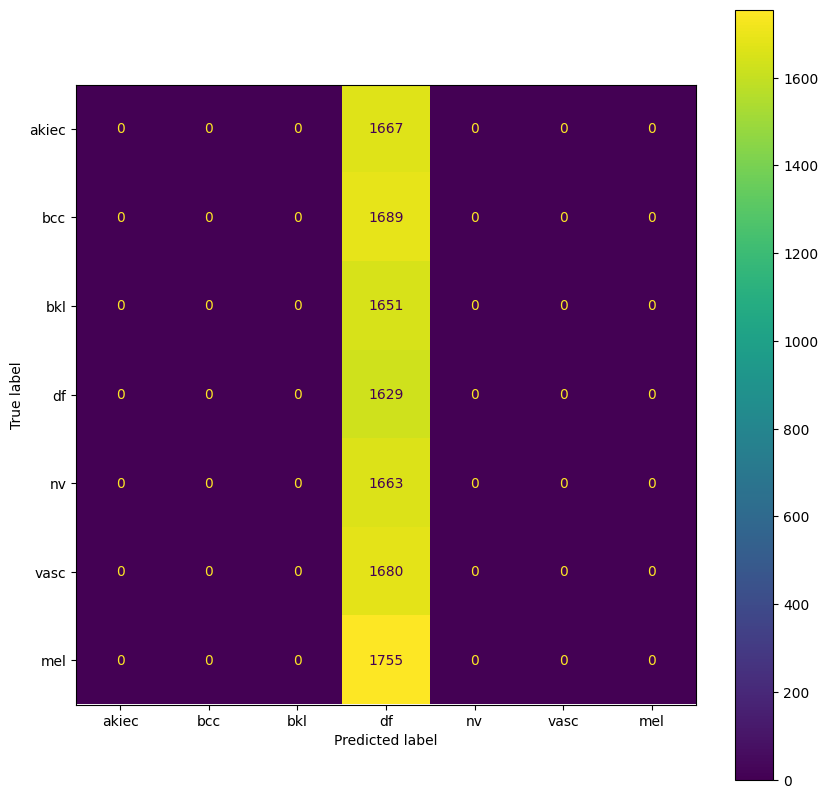

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_proba = model.predict(X_test/255)
model.evaluate(X_test/255, y_test)
y_pred = np.argmax(y_proba, axis=-1)

y_test_numbers = np.array([y.argmax() for y in y_test])
cm = confusion_matrix(y_test_numbers, y_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
print(classification_report(y_test_numbers, y_pred, target_names = labels))

In [ ]:
batch_size = batch_size
epochs = 200
model_history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
)

Epoch 1/200
276/276 [==============================] - 40s 102ms/step - loss: 1.7443 - accuracy: 0.2524 - val_loss: 1.5548 - val_accuracy: 0.3562
Epoch 2/200
276/276 [==============================] - 27s 98ms/step - loss: 1.3965 - accuracy: 0.4220 - val_loss: 1.3154 - val_accuracy: 0.4467
Epoch 3/200
276/276 [==============================] - 27s 99ms/step - loss: 1.2010 - accuracy: 0.5173 - val_loss: 1.0430 - val_accuracy: 0.5908
Epoch 4/200
276/276 [==============================] - 27s 98ms/step - loss: 1.0730 - accuracy: 0.5773 - val_loss: 0.9366 - val_accuracy: 0.6455
Epoch 5/200
276/276 [==============================] - 27s 99ms/step - loss: 0.9195 - accuracy: 0.6486 - val_loss: 0.7366 - val_accuracy: 0.7305
Epoch 6/200
276/276 [==============================] - 28s 100ms/step - loss: 0.7605 - accuracy: 0.7143 - val_loss: 0.6857 - val_accuracy: 0.7360
Epoch 7/200
276/276 [==============================] - 27s 98ms/step - loss: 0.6468 - accuracy: 0.7540 - val_loss: 0.5941 - val_

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 200, 'steps': 276}

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 256)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 256)       590080    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       590080    
                                                             

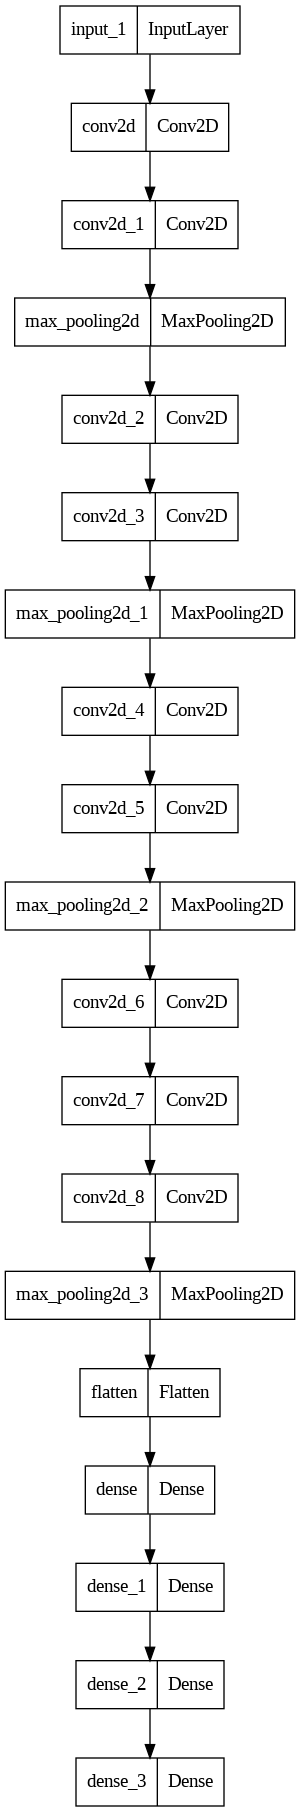

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

## __Model Evaluation__

In [ ]:
model.evaluate(X_test/255, y_test)

367/367 [==============================] - 3s 8ms/step - loss: 0.0960 - accuracy: 0.9809


[0.0959792211651802, 0.9809101819992065]

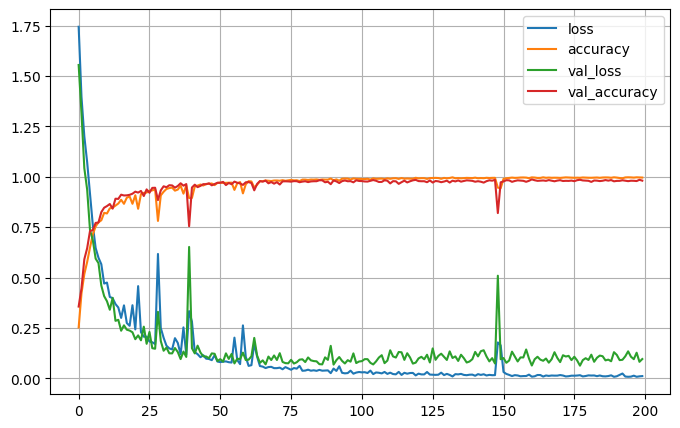

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [ ]:
y_proba = model.predict(X_test/255)
y_proba.round(2)

367/367 [==============================] - 3s 8ms/step


array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred[:10]

array([4, 0, 6, 4, 3, 6, 6, 0, 6, 6])

In [ ]:
y_pred_name = np.array(labels)[y_pred]
y_pred_name[:10]

array(['nv', 'akiec', 'mel', 'nv', 'df', 'mel', 'mel', 'akiec', 'mel',
       'mel'], dtype='<U5')

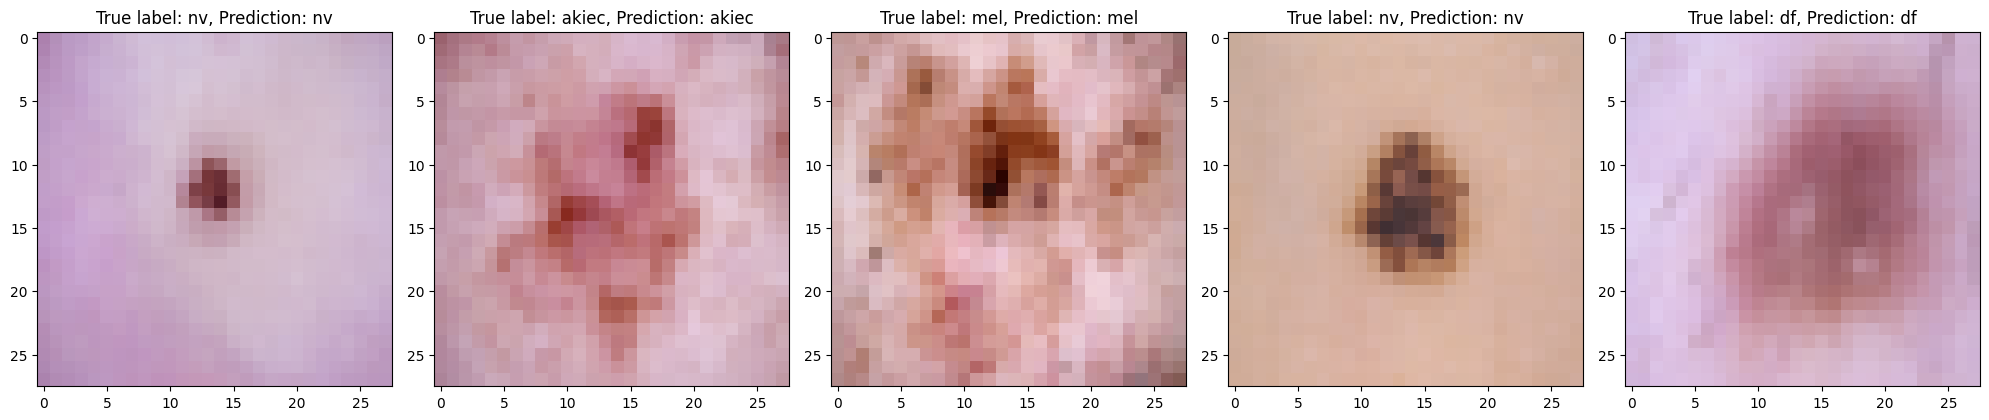

In [ ]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[i])
    plt.title('True label: {}, Prediction: {}'.format(labels[y_test[i].argmax()], y_pred_name[i]))
plt.tight_layout()

              precision    recall  f1-score   support

       akiec       0.99      1.00      1.00      1667
         bcc       0.99      1.00      1.00      1689
         bkl       0.98      0.99      0.99      1651
          df       1.00      1.00      1.00      1629
          nv       1.00      0.88      0.93      1663
        vasc       1.00      1.00      1.00      1680
         mel       0.92      0.99      0.96      1755

    accuracy                           0.98     11734
   macro avg       0.98      0.98      0.98     11734
weighted avg       0.98      0.98      0.98     11734



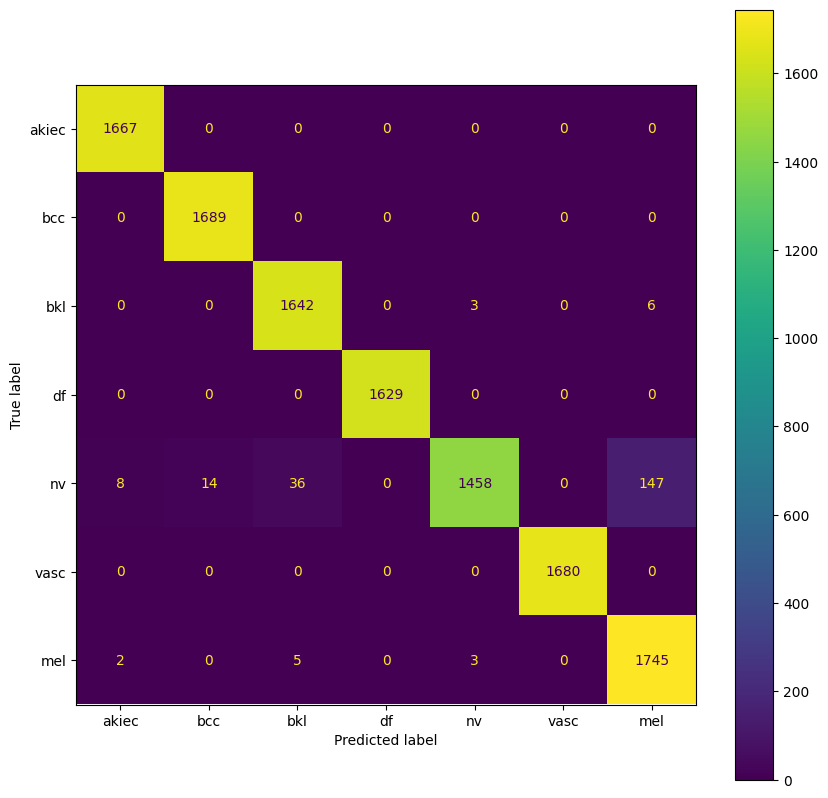

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
y_test_numbers = np.array([y.argmax() for y in y_test])
cm = confusion_matrix(y_test_numbers, y_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
print(classification_report(y_test_numbers, y_pred, target_names = labels))